# Классификация с помощью kNN. Кластеризация K-means

В этом уроке речь пойдет о так называемых _метрических алгоритмах_, то есть об алгоритмах, построенных на вычислении расстояний между объектами. Для начала нам нужно определить, какими способами эти расстояния можно вычислять.

## Меры и метрики расстояния между объектами

Понятие метрических пространств, метрик и некоторые их примеры уже рассматривались вами на курсе по линейной алгебре в рамках обучения по профессии. В этом разделе мы вспомним, какие могут быть метрики и их применение в плоскости машинного обучения.

Метрика является функцией, задающей расстояние в метрическом пространстве. Как мы помним из курса линейной алгебры, она должна удовлетворять трем аксиомам:

1. $\rho(x, y) \geq 0, \rho(x, y) = 0 \Leftrightarrow x = y;$
2. $\rho(x, y) = \rho (y, x);$
3. $\rho(x, y) \leq \rho(x, z) + \rho(z, y).$

Евклидова метрика

$$\rho(x, y) = \sqrt{\sum_{i=1}^{n}(x_{i}-y_{i})^{2}}$$

и манхэттенская метрика

$$\rho(x, y) = \sum_{i=1}^{n}|x_{i}-y_{i}|$$

уже должны быть вам знакомы. 

Также можно показать обобщение этих двух метрик - метрика Минковского:

$$\rho(x, y) = \left ( \sum_{i=1}^{n}|x_{i}-y_{i}|^{q} \right )^{\frac{1}{q}}.$$

При этом при $q = 1$ получаем манхэттенскую ($L_{1}$) метрику, при $q = 2$ - евклидову ($L_{2}$) метрику.

Кроме этого, в метрических алгоритмах часто используются так называемые меры близости. В отличие от метрик, которые тем меньше, чем объекты более похожи, меры близости увеличиваются при увеличении похожести (близости) объектов.

Примером такой функции может быть _косинусное сходство (косинусная мера)_:

$$\text{cos}\theta = \frac{\left \langle x, y \right \rangle}{||x||\cdot||y||} = \frac{\sum_{i=1}^{n}x_{i}y_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}\sqrt{\sum_{i=1}^{n}y_{i}^{2}}}.$$

Из этой функции также вытекает _косинусное расстояние_:

$$\rho_{cos}(x, y) = 1 - \text{cos}\theta = 1 - \frac{\sum_{i=1}^{n}x_{i}y_{i}}{\sqrt{\sum_{i=1}^{n}x_{i}^{2}}\sqrt{\sum_{i=1}^{n}y_{i}^{2}}}.$$

__Аналитический смысл__: объекты представлены в виде векторов, между двумя векторами образуется угол, значение косинуса этого угла – это и есть косинусная мера (следует из формулы скалярного произведения). 

__Почему эта функция - метрика?__

* f(x, x) = 0 - потому что arccos(1)=0
* f(x,y) = f(y,x) - по симметрии - очевидно, что угол между x и y равен углу между y и x
* f(x,y) >= 0 - потому что мы рассматриваем углы от 0 до 180 градусов
* неравенство треугольника (физический смысл)

Именно такая формула используется в функции `scipy.spatial.distance.cosine()` из библиотеки scipy, возвращающая косинусное расстояние между двумя векторами.

Косинусная мера часто используется в анализе текстов.

Кроме косинусной меры в прикладных задачах могут использоваться и другие функции - коэффициент Дайса, коэффициент Жаккара, коэффициент перекрытия (см. доп. материалы).

Формула нахождения косинусной меры похожа на _коэффициент корреляции_, который также может быть использован как мера близости и используется обычно в рекомендательных системах:

$$r = \frac{\sum_{i=1}^{n}((x_{i} - \bar{x})(y_{i} - \bar{y}))}{\sqrt{\sum_{i=1}^{n}(x_{i} - \bar{x})^{2}}\sqrt{\sum_{i=1}^{n}(y_{i} - \bar{y})^{2}}}$$

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import ListedColormap

In [2]:
# расстояние минковского (р=2 - эвклид, р=1 - квартальное)
def dist_mincovski(X1,X2,p):
    if p != 0:
        return np.sum(np.abs(X1-X2)** p) ** 1/p
    else: return 1

def dist_cos(X1,X2):
    
    return 1 - (np.dot(X1.reshape(1,-1), X2.reshape(-1,1)))/np.sum(X1 ** 2)/ np.sum(X2 ** 2)



C:\Users\miniAsus\AppData\Local\Temp\ipykernel_17668\2697109061.py:9: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.dot(X1.reshape(1,-1), X2.reshape(-1,1)))/np.sum(X1 ** 2)/ np.sum(X2 ** 2)


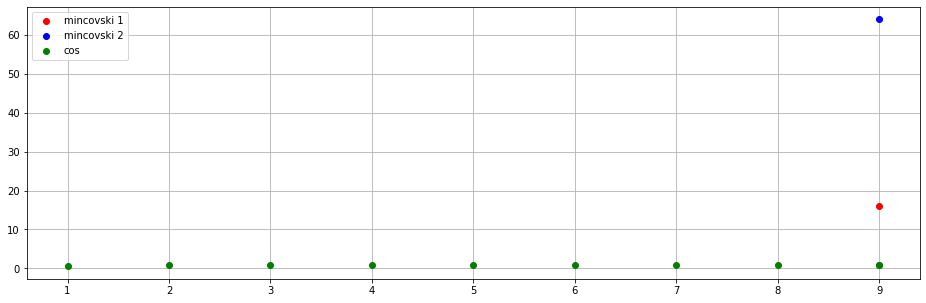

In [3]:
X1 = np.array([1,1])
plt.figure(figsize = (16,5))
               
               
for xi in range(10):
    X2 = np.array([xi,xi])
    r1 = dist_mincovski(X1,X2,1)
    r2 = dist_mincovski(X1,X2,2)
    rc = dist_cos(X1,X2)
    
    #plt.plot(xi,r1,'or')
    #plt.plot(xi,r2,'ob')
    plt.plot(xi,rc,'og')
    
    
#
plt.plot(xi,r1,'or', label = 'mincovski 1')
#
plt.plot(xi,r2,'ob', label = 'mincovski 2')
plt.plot(xi,rc,'og', label = 'cos')   
plt.legend()
plt.grid(True)
plt.show()
    

## Алгоритм kNN

Начнем обсуждение метрических алгоритмов с алгоритма kNN. Данный алгоритм является еще одним способом решения задачи классификации. Расшифровывается его название как "k ближайших соседей (k nearest neighbours)".

Суть его довольно проста и заключается в принципе отнесения объекту к тому классу, представители которого преобладают рядом с ним. Таким образом, упрощенно алгоритм классификации выглядит следующим образом:

- найти расстояние от объекта $u$ до каждого из объектов $x$ обучающей выборки;
- выбрать $k$ объектов, расстояние до которых минимально;
- отнести объект к классу, к которому относится большинство из выбранных $k$ ближайших соседей:

$$a(u) = \underset{y}{\text{argmax}}\sum_{i=1}^{k}[y_{u}^{(i)}=y],$$

то есть провести голосование.

При этом метод можно адаптировать под регрессию: в этом случае находится не метка класса, а среднее значение ответа среди $k$ соседей.

Интересной особенностью метода является то, что __на этапе обучения не строится модель__, а просто запоминается обучающая выборка. Вычисления начинаются именно на этапе решения задачи классификации конкретного объекта (поэтому этот алгоритм можно назвать ленивым).

Логичным усовершенствованием алгоритма kNN является добавление соседям весов (так называемое "взвешенное голосование"), зависящих от их порядкового номера или расстояния до классифицируемого объекта (чем ближе объект обучающей выборки, тем больше его вес).

От номера соседа $i$ веса можно определять как:

- $w(i) = q^{i}$,   $q \in (0,1)$;


- $w(i) = \frac{1}{i}$;


- $w(i) = \frac{1}{(i+a)^{b}}$;


- $w(i) = \frac{k + 1 - i}{k}$.


От расстояния $d$ веса можно определять как:

- $w(d) = q^{d}$,   $q \in (0,1)$;


- $w(d) = \frac{1}{(d+a)^{b}}$, брать вес $\frac{1}{d}$ по аналогии с номером соседа - неудачное решение, так как при $d = 0$ вес будет бесконечно большим, что приводит к переобучению


- $w(d) = \begin{cases}
\frac{d(z_{k}, x) - d(z_{i}, x)}{d(z_{k}, x) - d(z_{1}, x)}, & d(z_{k}, x) \neq d(z_{1}, x) \\ 
1, & d(z_{k}, x) = d(z_{1}, x)
\end{cases}$.

Существуют и другие способы вычисления весов.

Часто перед работой по алгоритму kNN требуется проводить нормализацию признаков, так как они могут иметь разные единицы измерения, что может искажать расстояние между объектами.

В общем и целом получается, что при работе с алгоритмом kNN исследователю требуется подобрать три параметра - количество соседей k, метрика расстояния и способ вычисления весов. Для получения лучшего качества работы алгоритма эти параметры нужно подбирать на отложенной выборке или при помощи кросс-валидации.

Реализуем алгоритм kNN с помощью Python.

Загрузим один из "игрушечных" датасетов из sklearn.

In [4]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

Разделим выборку на обучающую и тестовую

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

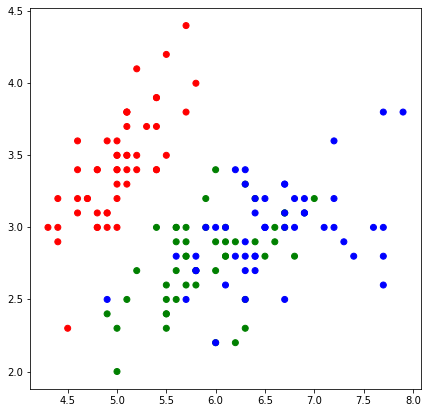

In [6]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

Используем евклидову метрику. Реализуем функцию для ее подсчета.

In [7]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
        #distance += np.abs(x1[i] - x2[i])
    
    return np.sqrt(distance)
    #return (distance)

Реализуем алгоритм поиска k ближайших соседей.

In [8]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
        #print(len(answers))    
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

Напишем функцию для вычисления точности

In [9]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

Проверим работу алгоритма при различных k

In [10]:
k = 1

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 1: 0.667


Построим график распределения классов.

In [11]:
def get_graph(X_train, y_train, k):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .2

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Трехклассовая kNN классификация при k = {k}")
    plt.show()

In [12]:
X_train.shape

(120, 2)

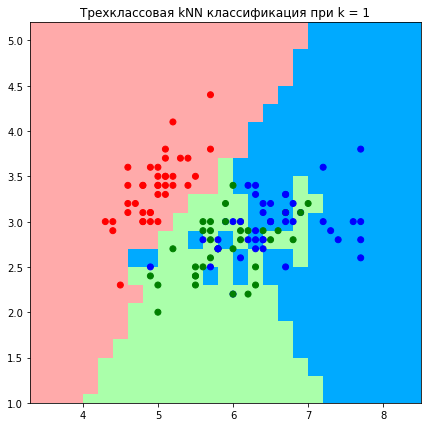

In [13]:
get_graph(X_train, y_train, k)

In [14]:
k = 3

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 3: 0.733


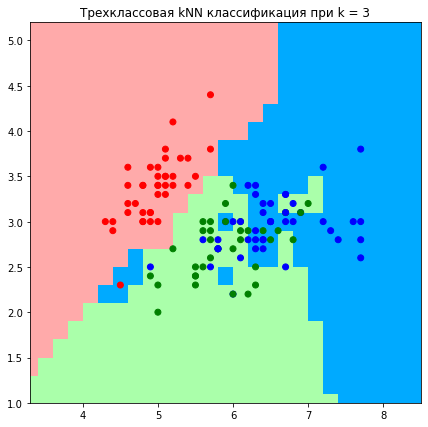

CPU times: total: 500 ms
Wall time: 606 ms


In [15]:
%%time
get_graph(X_train, y_train, k)

In [16]:
%%time
k = 6

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 6: 0.833
CPU times: total: 15.6 ms
Wall time: 30.3 ms


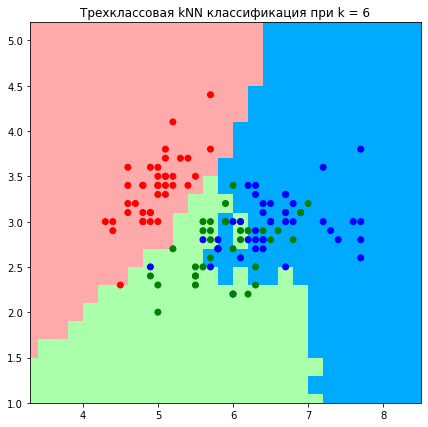

CPU times: total: 516 ms
Wall time: 583 ms


In [17]:
%%time
get_graph(X_train, y_train, k)

In [18]:
k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 10: 0.833


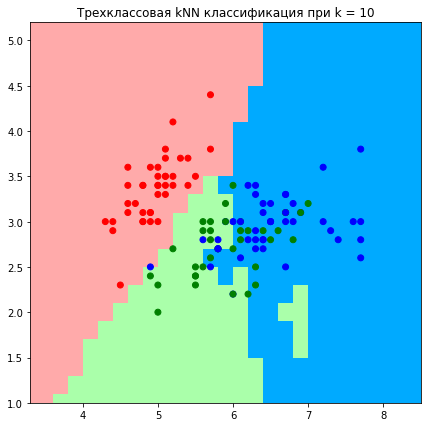

CPU times: total: 609 ms
Wall time: 716 ms


In [19]:
%%time
get_graph(X_train, y_train, k)

При увеличении k мы на графиках наблюдаем, как алгоритм меньше концентрируется на выбросах, однако, точность на тестовой выборке при этом увеличивается.

Рассматриваемый метод, несмотря на положительные стороны в виде легкости интерпретации, простоты и удобства использования, обладает некоторыми минусами, в частности, он плохо работает на датасетах с большим количеством признаков.

Например, если мы имеем три объекта, при этом второй отличается от первого только значением одного признака, но значительно, а третий отличается от первого незначительно в каждом признаке, расстояния от первого объекта до второго и третьего могут совпадать. Несущественные различия в каждом признаке могут иметь большее значение, чем большое различие в одном признаке. Такое поведение в ряде случаев будет нежелательным. 

Второй пример - случай, когда количество признаком сравнимо с количеством объектов. В этом случае может возникнуть ситуация, когда расстояния между любыми двумя объектами почти одинаковы. В двумерном пространстве (на плоскости) три точки могут располагаться по вершинам равностороннего треугольника, при этом расстояния между ними будут равны; в трехмерном пространстве то же самое справедливо для четырех точек на вершинах тетраэдра - расстояние между любыми двумя точками будет одинаково. В общем случае это означает, что в $n$-мерном пространстве можно выбрать $n+1$ точку так, чтобы расстояние между любыми двумя точками было одинаковым.

Третий пример - так называемое "проклятие размерности". Суть его заключается в том, что при наличии $n$ бинарных признаков в пространстве признаков будет возможно $2^{n}$ различных объектов вида $x = (0,1,0,0,1,...,1)$, и размер обучающей выборки, необходимый, чтобы описать все пространство объектов (то есть все возможные комбинации таких признаков) также будет порядка $2^{n}$. Чтобы покрыть не все пространство, а долю объектов $\alpha$ (то есть долю объема $\alpha$) нужно будет описать гиперкуб с длиной ребра $e_{p} = \alpha^{n}$. Например, в 10-мерном пространстве признаков чтобы покрыть 1% объема нужно взять гиперкуб с длиной $e_{10}(0,01) = 0.63$, то есть взять окрестность длиной больше половины ребра исходного пространства. Чем больше признаков, тем меньше будет область, которая покрывается во время поиска на заданном расстоянии. Таким образом, при сохранении требований по точности нахождения объекта в пространстве, количество требуемых данных для этого при увеличении количества признаков растет экспоненциально (подробнее про это явление см. в доп. материалах).

## Обучение без учителя. Кластеризация. K-means

До этого мы рассматривали методы обучения с учителем, то есть задачи, в которых изначально есть размеченная обучающая выборка данных с известными ответами на них и тестовая выборка, на которой проверяется качество алгоритма. В этом разделе речь пойдет об _обучении без учителя (unsupervised learning)_ - случае, когда в роли обучающей выборки выступает просто набор объектов $x_{1},...,x_{l}$, и он же выступает в роли тестовой выборки, а задача состоит в проставлении меток $y_{1},...,y_{l}$ так, что бы объекты с одной и той же меткой были похожи, а с разными - нет. То есть все объекты в пространстве признаков нужно разделить на группы, найти структуру в данных. Это и называется _кластеризацией_. Если раньше мы имели примеры ответов $y$, то сейчас их нет, и нужно строить свои отображения $x \rightarrow y$, отвечающие некоторым свойствам, например, тому, что похожие объекты отображаются в одну метку, а непохожие - в разные. По-простому задачу кластеризации можно сформулировать так: имеется множество точек, которые скапливаются в сгустки, нужно найти возможность относить точки к тому или иному сгустку и предсказывать, в какой сгусток попадет новая точка.

Примерами кластеризации может быть группирование новостей по темам, музыки по жанрам, клиентов по типу поведения и т.д.

Логично возникает вопрос, как измерять качество кластеризации. Есть большое количество инструментов оценки качества кластеризации, они разделяются на _внутренние_ (основанные только на свойствах выборки и кластеров) и _внешние_ (использующие данные об истинном распределении объектов по кластерам, если оно известно).

Примерами внутренних метрик могут быть:

- Внутрикластерное расстояние (также называется компактностью кластеров, cluster cohesion): $$\sum_{k=1}^{K}\sum_{i=1}^{l}[a(x_{i})=k]\rho(x_{i}, c_{k}),$$ где $K$ - количество кластеров, $c_{k}$ - центр кластера. Этот функционал нужно минимизировать, так как в идеальном случае все объекты в одном кластере одинаковы, и расстояние между ними равно нулю.


- Межкластерное расстояние (отделимость кластеров, cluster separation): $$\sum_{i,j=1}^{l}[a(x_{i}) \neq a(x_{j})]\rho(x_{i}, x_{j}).$$ Этот функционал наоборот нужно максимизировать, так как объекты из разных кластеров должны максимально различаться, то есть иметь максимальное расстояние между собой.

    - Часто используются те же формулы, но включающие не расстояние ρ, а его квадрат, получая квадратичное внутрикластерное и межкластерное расстояние:

    $$\sum_{k=1}^{K}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$
    $$\sum_{i,j=1}^{l}[a(x_{i}) \neq a(x_{j})]\rho^{2}(x_{i}, x_{j}).$$


- Среднее внутрикластерное расстояние (среднее расстояние внутри каждого кластера, просуммированное по всем кластерам) и среднее межкластерное расстояние (минимизируется и максимизируется, соответственно, по аналогии с двумя первыми функционалами):

    $$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho(x_{i}, c_{k}),$$
    $$\frac{1}{K}\sum_{i,j=1}^{l}[a(x_{i}) \neq a(x_{j})]\rho(x_{i}, x_{j}),$$ где $|k|$ - количество элементов в кластере под номером $k$.

    - По аналогии с квадратичным внутрикластерным и межкластерным расстоянием - среднее квадратичное внутрикластерное и межкластерное расстояние.

    $$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$
    $$\frac{1}{K}\sum_{i,j=1}^{l}[a(x_{i}) \neq a(x_{j})]\rho^{2}(x_{i}, x_{j}).$$ 

- Отношение внутрикластерного и межкластерного расстояний (или средних), минимизируется.


- Индекс Данна (Dunn Index): $$\frac{\text{min}_{1\leq k \leq k' \leq K}d(c_{k},c_{k'})}{\text{max}_{1\leq k \leq K} d(k)},$$ где $d(c_{k},c_{k'})$ - расстояние между кластерами $k$ и $k'$ (между их центрами), $d(k)$ - внутрикластерное расстояние для кластера $k$. Этот функционал требуется максимизировать.

In [20]:
# максимальное внутрикластерное расстояние
def in_claster(X,p):
    d = 0
    for i in range(X.shape[0]-1):
        for j in range(i+1,X.shape[0]-1):
            r = dist_mincovski(X[i,:],X[j,:],p)
            if r>d:
                d = r
    return d            

# минимальное межкластерное расстояние
def out_claster(X1,X2,p):
    d = np.inf
    for i in range(X1.shape[0]):
        for j in range(X2.shape[0]):
            r = dist_mincovski(X1[i,:],X2[j,:],p)
            if r<d:
                d = r
    return d         

Оценим расстояния между группами для набора примеров из ирисов Фишера (2 координаты):

In [21]:
# Среднее внутрикластерное расстояние
K = 0
K_max = []
for k in range(3):
    print('кластер :', k)
    r = in_claster(X_train[y_train == k,:],2)
    K += r
    K_max.append(r)
print('среденее внутриклассовое :',K/3)  

K_min = []
for k1 in range(2):
    for k2 in range(k1+1,2):
        print('пара: ',k1,k2)
        K_min.append(out_claster(X_train[y_train == k1,:],X_train[y_train == k2,:],2))
K_dunn = min(K_min) / max(K_max)
print('Индекс Данна :',K_dunn)  

кластер : 0
кластер : 1
кластер : 2
среденее внутриклассовое : 3.47
пара:  0 1
Индекс Данна : 0.013641133263378805


Индекс Данна : 0.0, т.к. есть одинаковые объекты.

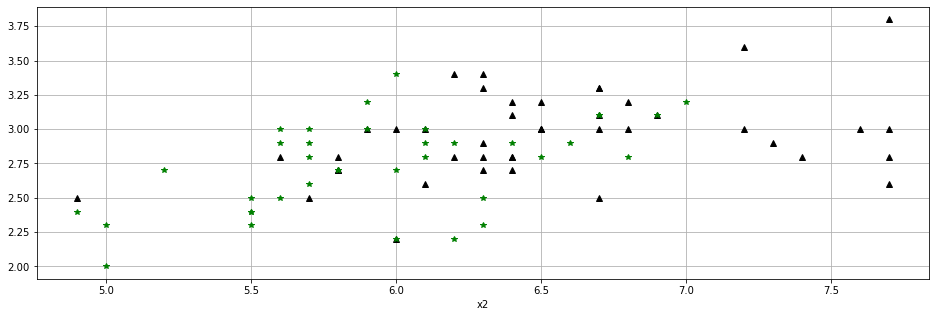

In [22]:
plt.figure(figsize = (16,5))
n1 = 0
n2 = 1
plt.plot(X_train[y_train == 2,n1],X_train[y_train == 2,n2],'^k')
plt.plot(X_train[y_train == 1,n1],X_train[y_train == 1,n2],'*g')
plt.grid(True)
plt.xlabel('x1')
plt.xlabel('x2')
plt.show()


Внешние метрики используются, если есть дополнительные знания о кластеризуемой выборке, например, известно истинное распределение по кластерам. Задачу можно рассматривать как задачу многоклассовой классификации с использованием соответствующих метрик. В этом случае примерами могут быть:

- Rand Index: $$Rand = \frac{TP+FN}{TP+TN+FP+FN}, $$ входящие в формулу обозначения мы встречали при изучении классификации и матриц ошибок. Здесь это количество пар объектов $(x_{i}.x_{j})$, которые принадлежат одному кластеру и одному классу (TP), одному кластеру, но разным классам (TN), разным кластерам, но одному классу (FP), разным кластерам и разным классам (FN). Этот индекс оценивает, сколько пар объектов, находившихся в одном классе, и пар объектов, находившихся в разных классах, сохранили это состояние после работы алгоритма. Он принимает значение от 0 до 1, где 1 - полное совпадение полученных кластеров и исходными классами, 0 - полное отсутствие совпадений.


- Jaccard Index: $$Jaccard = \frac{TP}{TP+TN+FP}.$$ Этот индекс похож на предыдущий, но он не учитывает пары объектов, находящихся в разных кластерах и разных классах. Имеет такую же область определения, как и Rand Index.


- F-мера: $$\sum_{j}\frac{l_{j}}{l}\underset{i}{\text{max}}\left(\frac{2\cdot precision(i,j) \cdot recall(i,j)}{precision(i,j) + recall(i,j)}\right),$$ здесь используются также знакомые из темы классификации параметры точности (precision) и полноты (recall). В данном случае они определяются как: $$precision(i,j)=\frac{l_{ij}}{l_{i}},$$ $$recall(i,j)=\frac{l_{ij}}{l_{j}},$$ где $l_{ij}$ - количество объектов $x_{n}$, принадлежащих кластеру $k_{i}$ и классу $c_{j}$; $l_{i} = |k_{i}|$ - размер кластера $k_{i}$; $l_{j} = |c_{j}|$ - размер класса $c_{j}$.

Про другие внутренние и внешние метрики качества кластеризации можно почитать в дополнительных материалах.

### Алгоритм K-means (K-средних)

Одним из самых простых и популярных алгоритмов кластеризации является алгоритм _K-means (K-средних)_. Заключается он в следующих шагах:

1 . Выбрать количество кластеров $k$, на которые будут делиться данные.

2 . Случайным образом выбрать в пространстве данных $k$ точек $c_{k}$ (центроидов) - центров будущих кластеров.

3 . Для каждой точки из выборки посчитать, к какому из центроидов она ближе.

4 . Переместить каждый центроид в центр выборки, отнесенной к этому центроиду, определив его как среднее арифметическое всех точек кластера:

$$c_{k} = \frac{\sum_{i=1}^{l}[a(x_{i})=k]x_{i}}{\sum_{i=1}^{l}[a(x_{i}) = k]}.$$
5 . Повторить шаги 3-4 до сходимости алгоритма (обычно это оценивается по величине смещения центроида после каждого шага - сходимость означает непревышение смещения какого-то заданного значения).

Результат работы алгоритма значительно зависит от начального выбора центроидов. Существует много методик их выбора, наиболее удачным из которых считается k-means++. Он заключается в последовательном выборе начальных приближений так, что вероятность выбрать в качестве центроида следующую точку пропорциональна квадрату расстояния от нее до ближайшего центроида.

Проблемой метода также является необходимость знать число кластеров, на которые будет делиться выборка. В случае, когда это число неизвестно, вариантом ее решения может быть последовательная кластеризация на разное число кластеров (например, от 1 до 10) с последующим анализом качества работы алгоритма, например, по сумме квадратов внутрикластерных расстояний $$\sum_{k=1}^{K}\sum_{i \in C_{k}}\rho(x_{i}, c_{k})^{2}$$ - выбирается такое число кластеров, начиная с которого при увеличении количества кластеров функционал падает незначительно.

Сделаем простую реализацию алгоритма K-means своими руками на Python.

Вначале сгенерируем три облака точек с помощью инструментов `sklearn`.

In [23]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=800, centers = 3, random_state=1)
X[:,1] *= 1

Изобразим точки на графике.

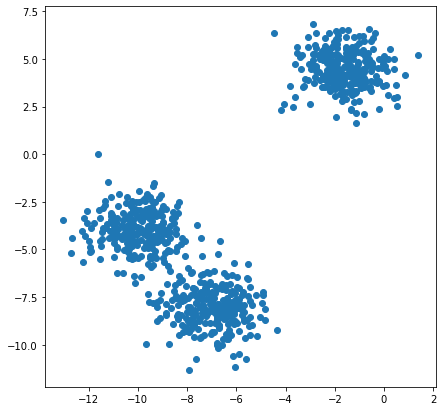

In [24]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

В качестве метрики расстояния будем использовать евклидово расстояние, функция для которого была написана ранее. В качестве центроидов выберем первые k элементов датасета. Реализуем основной цикл алгоритма.

In [25]:
def kmeans(data, k, max_iterations, min_distance):    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}
        
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [26]:
def kmeans_predict(centroids, data):    
    # инициализируем центроиды как первые k элементов датасета
    classes = [i for i in range(len(centroids))]
    label = []
    # классифицируем объекты по центроидам
    for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            #print(classification)
            label.append(classification)
    return label

Напишем функцию для визуализации кластеров

In [27]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b','m','y']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
    plt.grid(True)        
    plt.show()

In [28]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

Проверим результат алгоритма после одной итерации

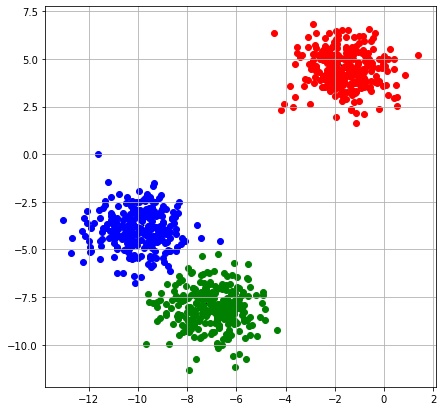

In [29]:

centroids, clusters = kmeans(X[10:,:], k, max_iterations, min_distance)

visualize(centroids, clusters)

Проверим работу алгоритма при различном числе итераций.

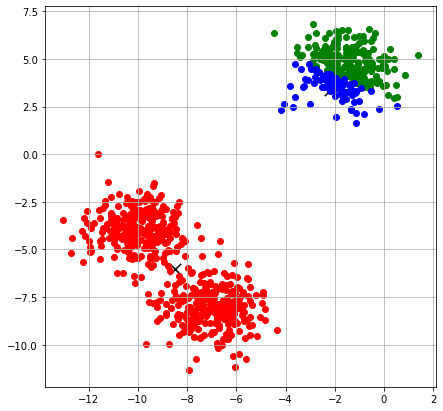

In [30]:
max_iterations = 3

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

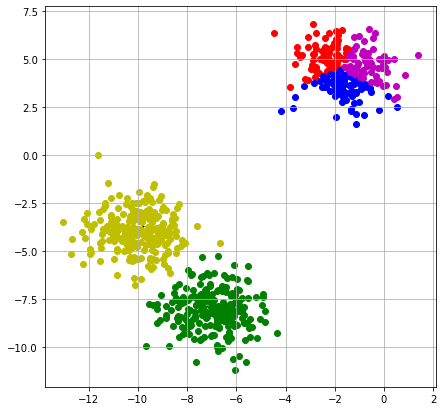

In [31]:
max_iterations = 15
k=5
centroids, clusters = kmeans(X[100:,:], k, max_iterations, min_distance)

visualize(centroids, clusters)

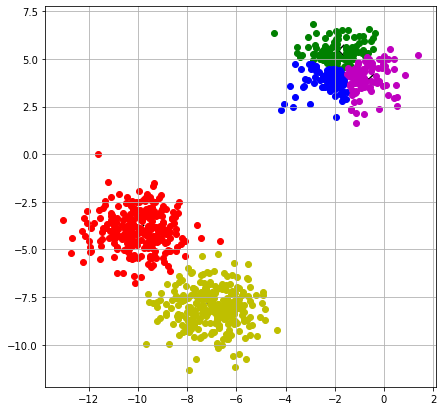

In [32]:
max_iterations = 10

centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

Видно, как при увеличении количества итераций центроиды перемещаются в центр образующихся кластеров.

In [33]:
def get_clast( h = 0.2,xminmax = [], yminmax=[], centroids =[]):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF','#000AFF','#A00AFF','#BB0AFF'])

    # Расчет пределов графика
    xx, yy = np.meshgrid(np.arange(xminmax[0], xminmax[1], h), np.arange(yminmax[0], yminmax[1], h))

    # Получим предсказания для всех точек
    Z =  kmeans_predict(centroids, np.c_[xx.ravel(), yy.ravel()])

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    for centroid in centroids:
            plt.plot(centroid[0], centroid[1],'xk')
    

    # Добавим на график обучающую выборку
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("кластеризация  ")
    plt.show()

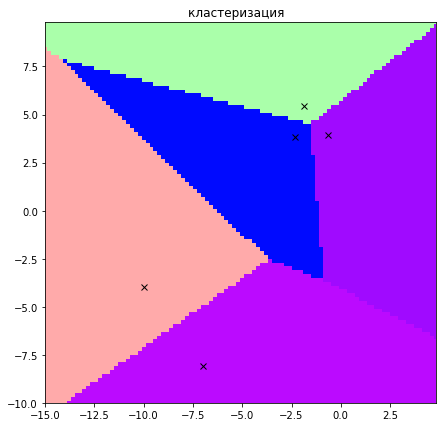

In [34]:
get_clast( h = 0.2,xminmax = [-15,5], yminmax=[-10,10], centroids =centroids)

Как и говорилось ранее, метод K-means очень чувствителен к выбору начальных центров кластеров, и это является одним из его основных минусов, среди которых также сложность работы с разными формами кластеров (они, например, могут быть вытянутыми, образовывать фигуры и т.п.). В связи с этим существуют другие методы кластеризации, о которых можно прочитать в дополнительных материалах. Там же есть сравнение работы алгоритмов с кластерами различных форм.

DBSCAN

In [35]:
from sklearn.cluster import DBSCAN
 

dbscan = DBSCAN(eps=0.5, min_samples=3)
 
dbscan.fit(X)
 
# Готово! Распечатаем метки принадлежности к кластерам
print(dbscan.labels_)

[ 0  1  1  1  0  1  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  1  1  0
 -1  0  1 -1  0  0  0  1  0  0  2  1  0  0  0  1  0  0  0  1  0  1  0  0
  0  0  1  0  0  0  0  0  0  0  0  0  0  1  1  1  1  0  1 -1  0  0  1  1
  1  1  0  1  0  1  0  0  1  0  0  0  0  0  1  1  1  0  0  1  3  0  0  0
  0  0  0  1  1  0  1  1  0  1  0  0  1  1  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  1  0  0  0 -1  0  0  0 -1  1  1  0  0  3  0  1  0  1  0  1
  0  0  1  1  0  0  0  0  1  0  0  0  0  1  0 -1  0  1  0  0  1  0  0  1
  0  0  1  0  0  0  0  0  0  0 -1  0  0  0  1  0  0  0  0  0  1  1  1  0
  1  0 -1  0  4  0  1  1  0  0  0  0  0  0  5  1  0 -1  1  0  1  1  0 -1
  0  1  0  0  1  0  1  1  1  0  1  0  1  1  0  0  1  0  0  0  1  0  1  1
  0  1  0  0  0  1  1  1  0  1  0  0  1  0  1  0  1  0  1  0  1  0  1  0
  0  0  0  0  0  0  1 -1  0  0  0  0  2  1  1  1 -1  1  0  0  1  0  1  0
  0  0  0  5  0  0  0  0  1  1  1  0  0  0  0  0  0  0  1  0  1  1  1  0
  1  0  1  1  0  0  0  0  0  0  0  0  0  1  0  0  1

In [36]:
def get_clast_DBSCAN( X_test = [], label = []):
    cmap_light = ['#000000', '#0AFFAA','#00A0FF','#FFAAAA', '#AAFFAA','#00AAFF','#000AFF','#A00AFF','#BB0AFF','#BBBAFF']
   

    # Построим график
    
    plt.figure(figsize=(7,7))
    # Добавим на график обучающую выборку
    for i,x in enumerate(X_test.tolist()):
        plt.scatter(x[0], x[1],color=cmap_light[label[i]])
   
    plt.grid(True)
    plt.title("кластеризация  ")
    plt.show()

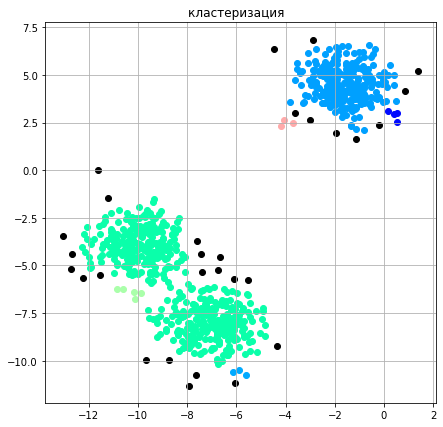

In [37]:
get_clast_DBSCAN(X_test = X,label=np.array(dbscan.labels_)+1)

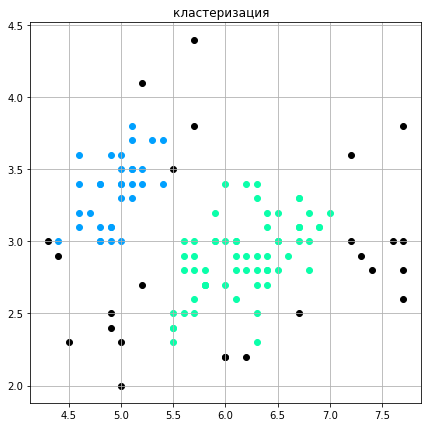

In [38]:
dbscan = DBSCAN(eps=0.25, min_samples=5)
 
dbscan.fit(X_train)

get_clast_DBSCAN(X_test = X_train,label=np.array(dbscan.labels_)+1)

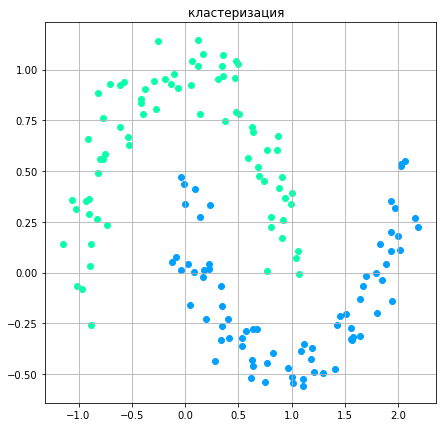

In [39]:
from sklearn.datasets import make_moons
noisy_moons = make_moons(n_samples=150, noise=.1)

get_clast_DBSCAN(X_test = noisy_moons[0],label=np.array(noisy_moons[1]+1))

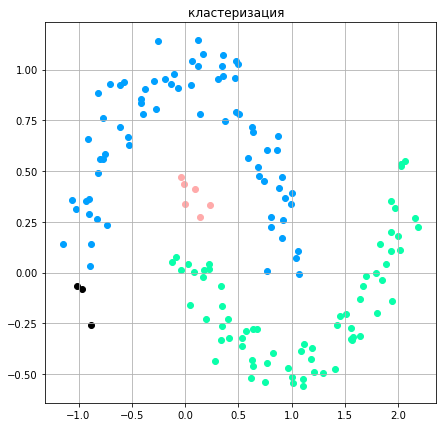

In [40]:

dbscan = DBSCAN(eps=0.22, min_samples=5)
 
dbscan.fit(noisy_moons[0])

get_clast_DBSCAN(X_test = noisy_moons[0],label=np.array(dbscan.labels_)+1)

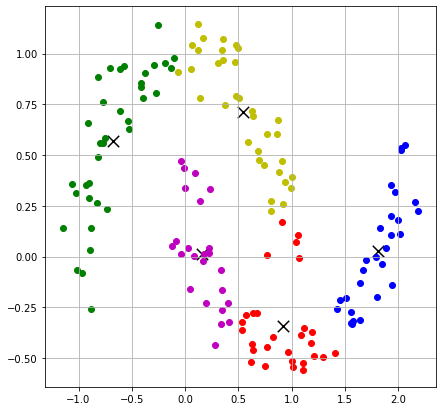

In [41]:
max_iterations = 10
k = 5
min_distance = 0.1
centroids, clusters = kmeans(noisy_moons[0], k, max_iterations, min_distance)

visualize(centroids, clusters)

## Литература

1. Факторный, дискриминантный и кластерный анализ: Пер. с англ./Дж.-О. Ким, Ч. У. Мьюллер, У. Р. Клекка и др.; Под ред. И. С. Енюкова. — М.: Финансы и статистика, 1989.— 215 с.
2. [Об использовании мер сходства при анализе документации](http://ceur-ws.org/Vol-803/paper18.pdf)
3. [KNN Algorithm](https://medium.com/datadriveninvestor/knn-algorithm-and-implementation-from-scratch-b9f9b739c28f)
4. [Проклятие размерности](http://www.machinelearning.ru/wiki/index.php?title=%D0%9F%D1%80%D0%BE%D0%BA%D0%BB%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B8); ([Иллюстрация](https://www.youtube.com/watch?v=R2hQIJb0Lis))
5. [Оценка качества кластеризации](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)
6. [Обзор алгоритмов кластеризации данных](https://habr.com/ru/post/101338/)
7. [Работа алгоритмов кластеризации на классах разной формы](https://scikit-learn.org/stable/modules/clustering.html)

## Summary

__kNN__
* Метрический алгоритм классификации по "ближайшим соседям"
* Разновидности: ближайший сосед, k ближайших соседей, k взвешанных ближайших соседей
* Алгоритм интерпретируем
* В основе алгоримта лежит _гипотеза компактности_: если мера сходства объектов введена достаточно удачно, то схожие объекты гораздо чаще лежат в одном классе, чем в разных
* Проблемы и их решения
    * Выбор метрики __->__ нет единого алгоритма, позволяющего выбрать метрику, поэтому используют что-то из "стандартного" (например, Евклидова)
    * Выбор числа соседей k __->__ подбор на основании кросс-валидации, чаще даже по контролю одного объекта (leave-one-out cross-validation)
    * Выбросы/шум __->__ ручной отсев, придание меньшего веса, либо поиск типичных представителей классов (эталонов) алгоритмом STOLP, тогда объект можно классифицировать по ближайшему эталону
    * Большие выборки __->__ уменьшение выборки за счет удаления неинформативных объектов (например, оставить только эталоны), либо более быстрые структуры данных (например, kd-деревья)
    * Много признаков - "проклятие размерности" - суммы большого числа отклонений по отдельным признакам с большой вероятностью имеют очень близкие значения (согласно закону больших чисел), то есть в пространстве высокой размерности все объекты примерно одинаково далеки друг от друга __->__ предварительный отбор признаков (feature selection)

__k-means__
* Кластеризует неразмеченные объекты, помогая найти структуру в данных
* Использует метрику близости, является метрическим алгоритмом
* Можно использовать для генерации нового признака - номера кластера
* Проблемы и их решения
    * Алгоритм чувствителен к выбору начальных центров кластеров __->__ как вариант, на начальном этапе принимать в качестве центров самые отдаленные точки
    * Необходимо заранее знать количество кластеров __->__ выбор исходя из природы данных, либо оценка исходя из распределений признаков или 2D представления объектов (PCA)
    * Не справляется с задачей, когда объект принадлежит к разным кластерам в равной степени или не принадлежит ни одному __->__ выбирать случайно ответ, либо ввести более сложную функцию весов
    * Не гарантируется достижение глобального минимума суммарного квадратичного отклонения, а только одного из локальных минимумов (пример на картинке ниже) __->__ инициализировать начальные центры не случайно
    
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7c/K-means_convergence_to_a_local_minimum.png/1920px-K-means_convergence_to_a_local_minimum.png" style="width: 1000px;">

## Д/з

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов соседей по любому из показанных на уроке принципов.
2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока.

## OOB

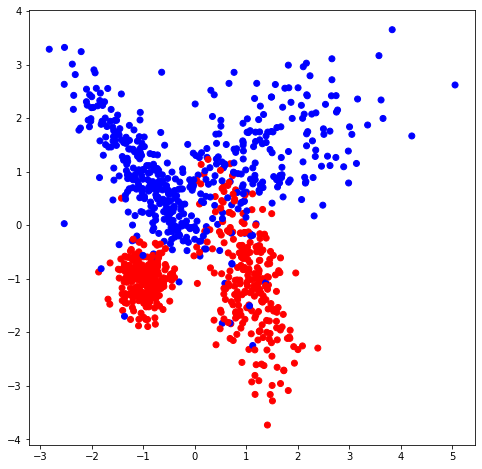

In [42]:
import numpy as np
import sklearn.datasets as datasets


# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000,n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=2, random_state=5)


# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
np.random.shuffle(np.arange(classification_labels.shape[0]))

In [45]:
frq = np.zeros_like(classification_labels) # счетчик 
pred = np.zeros_like(classification_labels).astype(float)  #  накопление предиктов
n_split = 500
# строим случайный лес 
RF_=[]
for i in range(100):
    ind_ = np.arange(classification_labels.shape[0])
    np.random.shuffle(ind_)
    #print(ind_)
    ind_test = ind_[:n_split].tolist()
    ind_tr = ind_[n_split:].tolist()
    #print(ind_test)
    x_tr,y_tr = classification_data[ind_tr,:], classification_labels[ind_tr]
    x_test,y_test = classification_data[ind_test,:], classification_labels[ind_test]
    tree_i =DecisionTreeClassifier().fit(x_tr,y_tr)
    y_pred = tree_i.predict(x_test)
    RF_.append(tree_i)
    #oob
    pred[ind_test] += np.abs(y_test.astype(float) == y_pred).astype(float)
    frq[ind_test] += 1
    
error = np.mean(pred / frq)
error
    

0.9001669460629708

In [46]:
frq

array([50, 49, 44, 49, 57, 46, 55, 46, 48, 55, 54, 53, 53, 53, 42, 51, 56,
       43, 45, 49, 58, 53, 51, 50, 42, 50, 58, 58, 47, 34, 47, 48, 47, 53,
       49, 57, 43, 59, 58, 45, 45, 54, 43, 52, 55, 55, 48, 46, 44, 54, 54,
       51, 45, 41, 45, 49, 55, 56, 58, 50, 44, 46, 49, 52, 48, 54, 52, 49,
       53, 45, 41, 54, 56, 52, 48, 51, 51, 63, 57, 47, 47, 51, 51, 57, 49,
       46, 53, 61, 43, 55, 52, 51, 57, 55, 48, 40, 49, 51, 54, 48, 54, 51,
       46, 42, 51, 51, 49, 52, 50, 44, 51, 50, 57, 55, 51, 48, 54, 48, 54,
       50, 51, 54, 46, 57, 48, 55, 39, 53, 45, 53, 42, 48, 46, 46, 61, 54,
       51, 34, 49, 50, 46, 45, 56, 58, 47, 55, 59, 54, 52, 48, 48, 51, 45,
       50, 47, 45, 52, 59, 48, 46, 54, 56, 43, 54, 51, 53, 52, 47, 49, 45,
       47, 50, 47, 46, 42, 45, 40, 49, 52, 45, 51, 48, 46, 50, 53, 45, 53,
       48, 49, 43, 49, 55, 50, 55, 36, 48, 50, 60, 56, 48, 51, 50, 50, 51,
       52, 54, 43, 44, 50, 42, 48, 50, 44, 50, 55, 49, 52, 61, 53, 50, 52,
       48, 52, 45, 54, 57

## **Реализация домашнего задания.**

1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов соседей по любому из показанных на уроке принципов.

In [47]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [48]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [49]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

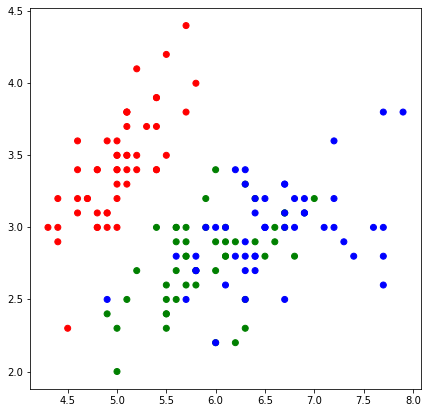

In [50]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [51]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [52]:
def w_coeff_1(q, d):

    return q ** d # w(i) = q^i или w(i) = q^d в зависимости от того, что передать в параметре d

In [53]:
def w_coeff_2(q, d):

    return 1 / (d + q)**(1 + q)   # w(i) = 1 / (d+a)^b или  w(i) = 1 / i

In [54]:
def knn(x_train, y_train, x_test, k, q = 1, wv=1):

    # print(k, q, wv)

    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            weight = 1
            # Расчет весового коэффициента, в случае задания варианта расчета.
            if wv == 1:
                weight = w_coeff_1(q, len(test_distances)+1) # w(i) = q^i
            elif wv == 2:
                weight = w_coeff_1(q, distance) # w(i) = q^d
            elif wv == 3:
                weight = w_coeff_2(q, distance)  # w(i) = 1 / (d+a)^b
            elif wv == 4:
                weight = w_coeff_2(q, len(test_distances)+1)  # w(i) = 1 / i

            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((weight*distance, y_train[i])) 
            # test_distances.append((distance, y_train[i])) 

        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [55]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))


In [56]:
k = 3
q = 0.5

y_pred = knn(X_train, y_train, X_test, k, q, 0)

print(y_test)
print(y_pred)

print(f'Точность алгоритма при k = {k}, q = {q} : {accuracy(y_pred, y_test):.3f}')

[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 1 1 0 2 1 0 0 1 2]
[0, 1, 2, 0, 2, 2, 1, 0, 0, 1, 1, 0, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1]
Точность алгоритма при k = 3, q = 0.5 : 0.733


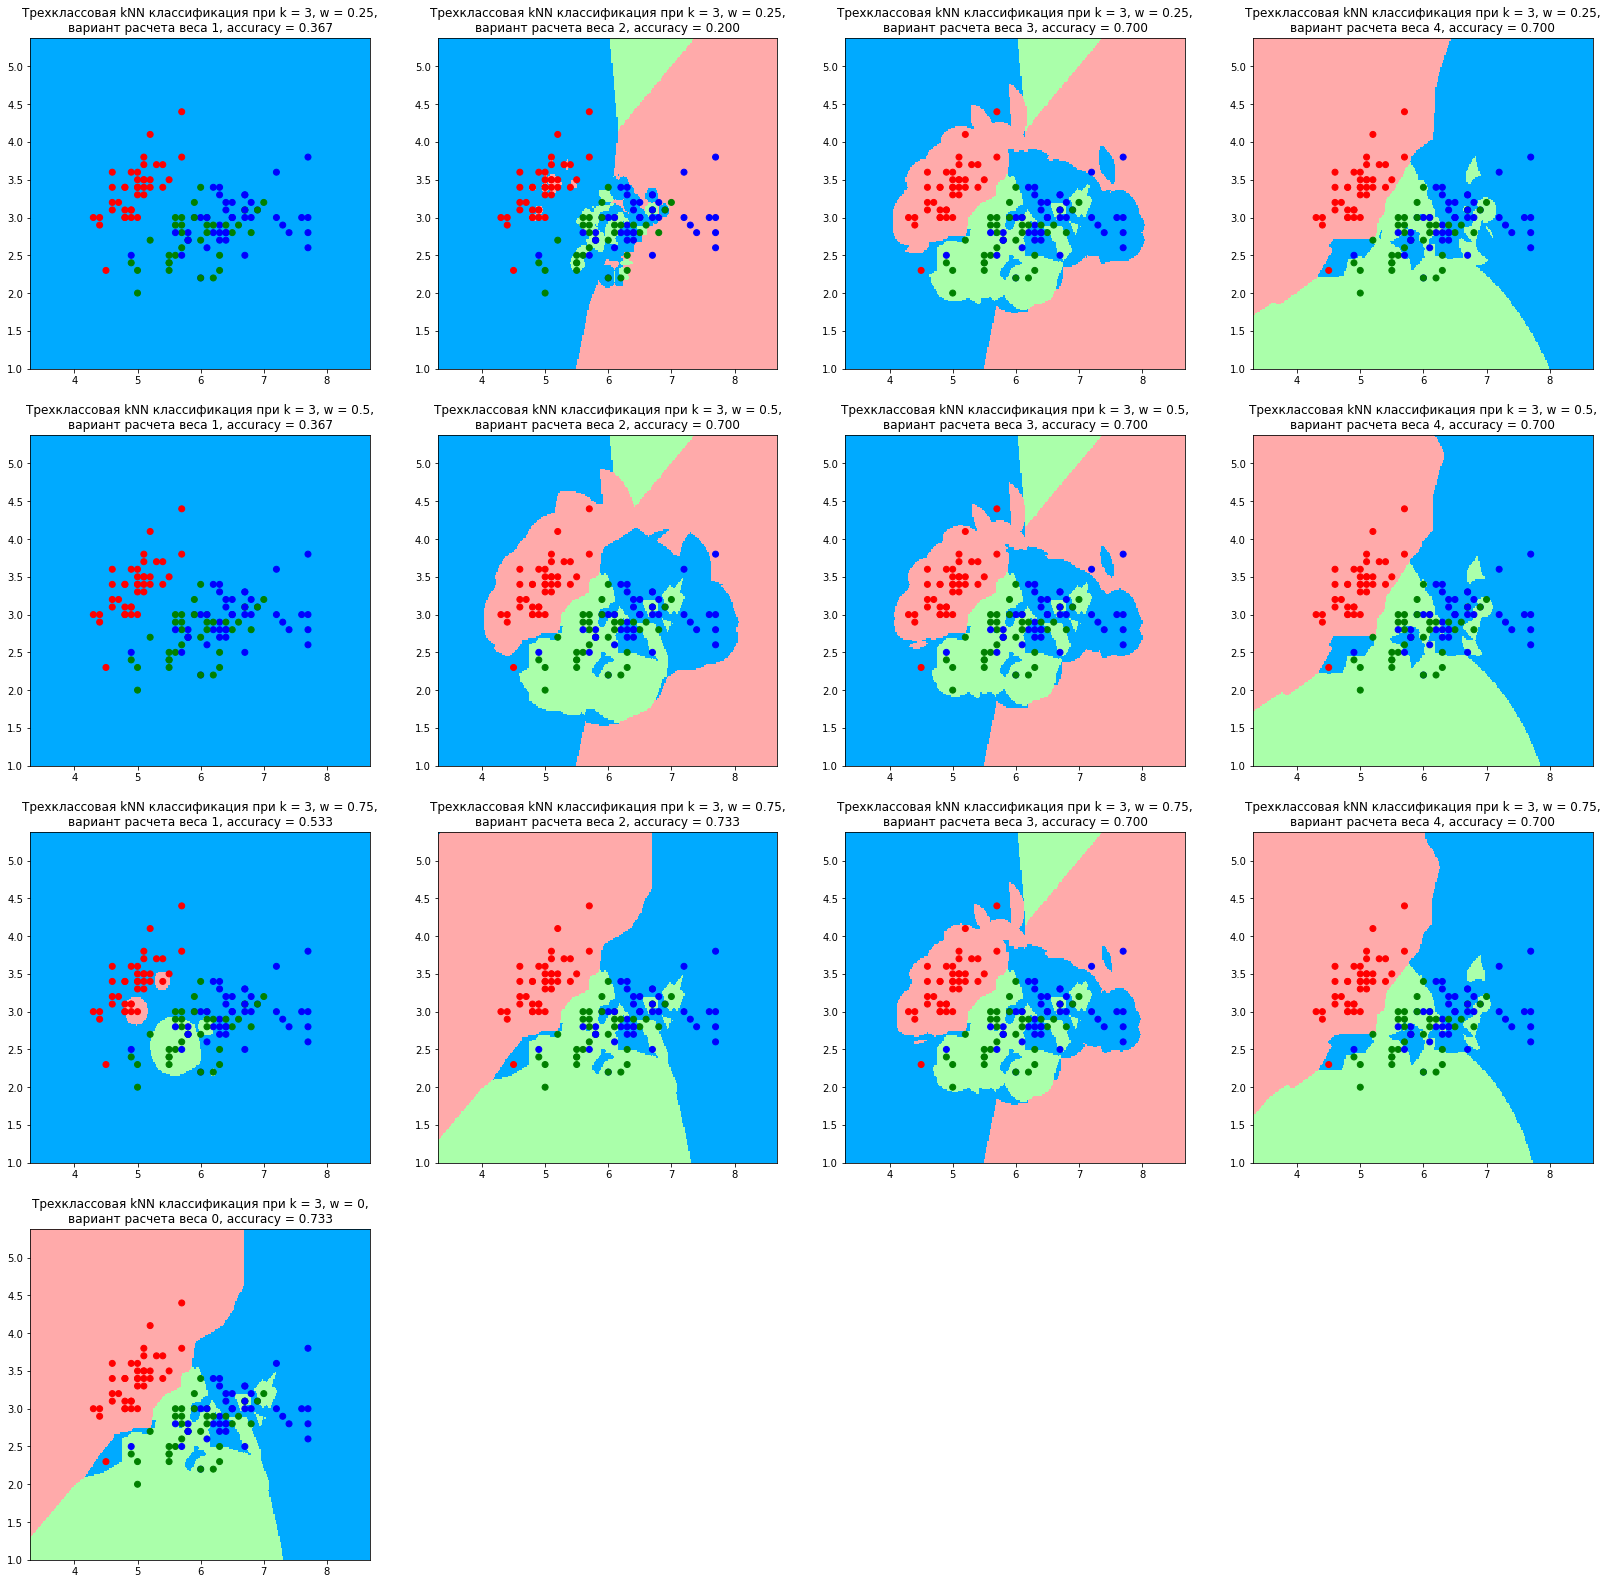

In [57]:
h = .02

# Расчет пределов графика
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

plt.figure(figsize = (28, 28))

count = 0

k = 3

for q in [0.25, 0.5, 0.75]:
    for weights_version in [1, 2, 3, 4]:
    
        count += 1

        predict = knn(X_train, y_train, X_test, k, q, weights_version)
        accur = accuracy(predict, y_test)
        # print(f'Точность алгоритма при k = {k}, q = {w}\nвариант расчета веса {wv} : {accuracy(predict, y_test):.3f}')
    
        # Получим предсказания для всех точек
        Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, q, weights_version)

        # Построим график
        Z = np.array(Z).reshape(xx.shape)

        plt.subplot(4,4,count)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

        # Добавим на график обучающую выборку
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"Трехклассовая kNN классификация при k = {k}, w = {q},\nвариант расчета веса {weights_version}, accuracy = {accur:.3f}")

count += 1

predict = knn(X_train, y_train, X_test, k, 0, 0)
accur = accuracy(predict, y_test)
# print(f'Точность алгоритма при k = {k}, q = {w}\nвариант расчета веса {wv} : {accuracy(predict, y_test):.3f}')

# Получим предсказания для всех точек
Z = knn(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, 0, 0)

# Построим график
Z = np.array(Z).reshape(xx.shape)

plt.subplot(4,4,count)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Добавим на график обучающую выборку
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title(f"Трехклассовая kNN классификация при k = {k}, w = {0},\nвариант расчета веса {0}, accuracy = {accur:.3f}")

plt.show()

На графиках отражена динамика изменения коэффициент q (увеличение сверху вниз) из формул для расчета w(i). А справа налево применяются различные варианты формулы для расчета w(i).

Самый нижний график - расчет без весового коэффициента. Как на уроке.

К сожалению, accuracy самый большой 0.733 только у алгоритма из лекции и у варианта w(i) = q^d где d-расстояние, а q = 0.75. 

Остальные эксперименты привели к ухудшению качества. Но, думю, что для учебного задания это тоже неплохой результат.

2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока.

In [58]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=500)

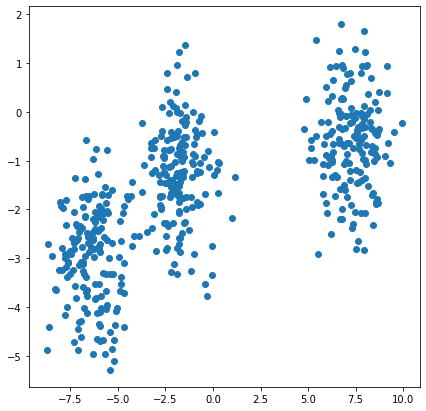

In [59]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [60]:
def kmeans(data, k, max_iterations, min_distance):
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):

        # Создадим словарь для классификации
        classes = {i: [] for i in range(k)}

        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break

    
    return old_centroids, classes

In [61]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [62]:
def kmeans_quality(centroids, clusters):
  k=0
  quality=0
  for c in centroids:
      for x in clusters[k]:
        quality += e_metrics(x, c)**2
      k+=1
  return quality

In [63]:
def visualize(centroids, classes):
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

In [64]:
# определим максимальное количество итераций
max_iterations = 10

# и минимальное расстояние между центроидами до пересчета и после него, при котором нужно остановить алгоритм
min_distance = 1e-4

# сразу определим известное нам количество кластеров
k = 3

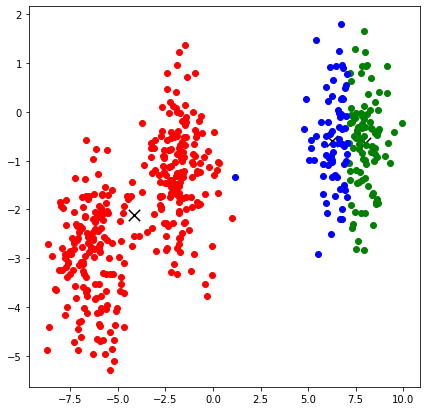

In [65]:
centroids, clusters = kmeans(X, k, max_iterations, min_distance)

visualize(centroids, clusters)

In [66]:
kmeans_q=[]
for k in range(1,11):
  centroids, clusters = kmeans(X, k, max_iterations, min_distance)
  kmeans_q.append(kmeans_quality(centroids, clusters))

In [67]:
print('среднее квадратичные внутриклассовые расстояния:\n', np.round(kmeans_q))

среднее квадратичные внутриклассовые расстояния:
 [17582.  2965.  2847.  2780.   776.   740.   723.   610.   515.   425.]


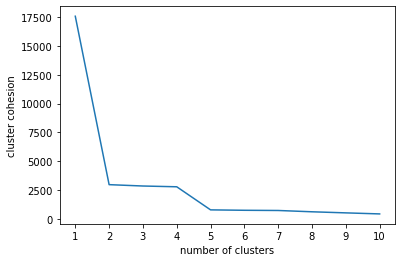

In [68]:
k=np.arange(10)
plt.xlabel('number of clusters')
plt.xticks(k+1)
plt.ylabel('cluster cohesion')
plt.plot(k+1,kmeans_q)

**Вывод:** При увеличении количества кластеров среднее квадратичное внутриклассовое расстояние постепенно уменьшается, снижается также и его изменение.